In [1]:
# Fixing automatic autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np 
import time
import matplotlib.pyplot as plt

from monai.losses import DiceLoss
from torch.optim import Adam

from utils import (
    read_data, 
    get_data_loader
)

from deeplabv3.network.modeling import _segm_resnet


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

batch_size = 2
model = _segm_resnet(
    name="deeplabv3plus",
    backbone_name="resnet50",
    num_classes=3,
    output_stride=8,
    pretrained_backbone=True,
)

# Setting up parallelization, if applicable
device_count = torch.cuda.device_count()
if device_count > 1:
    print("Using", device_count, "GPUs!")
    model = torch.nn.DataParallel(model)

    # Parallelization allows for a higher batch size
    batch_size *= device_count 
    
model.to(device)

device: cpu


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [4]:
on_idun = False

if on_idun:
  data_path = "/cluster/projects/vc/data/mic/open/OCELOT/ocelot_data"
else: 
  data_path = "ocelot_data/"
train_data, val_data, test_data = read_data(data_path)

Skipped file number 217 as the .csv was empty.
Skipped file number 042 as the .csv was empty.
Skipped file number 053 as the .csv was empty.
Skipped file number 008 as the .csv was empty.
Skipped file number 392 as the .csv was empty.
Skipped file number 570 as the .csv was empty.
Skipped file number 558 as the .csv was empty.


In [5]:
train_segmented_cell_folder = os.path.join(data_path, "annotations/train/segmented_cell/")
val_segmented_cell_folder = os.path.join(data_path, "annotations/val/segmented_cell/")
test_segmented_cell_folder = os.path.join(data_path, "annotations/test/segmented_cell/")

train_data_loader = get_data_loader(train_data, train_segmented_cell_folder, batch_size)
val_data_loader = get_data_loader(val_data, val_segmented_cell_folder, batch_size)
test_data_loader = get_data_loader(test_data, test_segmented_cell_folder, batch_size)

loss_function = DiceLoss(softmax=True)
optimizer = Adam(model.parameters(), lr=1e-3)

/Users/jarl/school/fall23/specialization_project/histopathology_segmentation/utils.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(resized_tensor, dtype=torch.uint8)


# Training the model

In [9]:
def plot_loss(
    num_epochs: int,
    val_losses: list,
    train_losses: list,
    save_path: str = "plots/loss.png",
):
    x = np.arange(num_epochs)

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x, train_losses)
    plt.title("Training loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(x, val_losses)
    plt.title("Validation Loss")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")

    plt.tight_layout()

    plt.savefig(save_path, dpi=300)
    plt.close()


def run_training_epoch(train_data_loader, device, optimizer, model, loss_function):
    model.train()
    train_loss = 0
    break_early = device == torch.device("cpu")
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs.to(torch.float32))

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # No point in running the entire loop without GPU
        if break_early:
            print("Training loop stopped early as the code is running on CPU")
            break

    if not break_early: 
        train_loss /= len(train_data_loader)
    return train_loss


def run_validation_epoch(val_data_loader, device, loss_function):
    model.eval()
    val_loss = 0
    break_early = device == torch.device("cpu")
    with torch.no_grad():
        for inputs, labels in val_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs.to(torch.float32))
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # No point in running the entire loop without GPU
            if break_early:
                print("Validation loop stopped early as the code is running on CPU")
                break

    if not break_early: 
        val_loss /= len(val_data_loader)
    return val_loss


def train(
    model,
    train_data_loader,
    val_data_loader,
    optimizer,
    loss_function,
    num_epochs,
    device,
):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        start = time.time()
        train_loss = run_training_epoch(
            train_data_loader, device, optimizer, model, loss_function
        )
        train_losses.append(train_loss)

        val_loss = run_validation_epoch(val_data_loader, device, loss_function)
        val_losses.append(val_loss)
        end = time.time()

        print(
            f"Epoch {epoch + 1}, "
            f"Training Loss: {train_loss}, "
            f"Validation Loss: {val_loss}, "
            f"epoch_time: {end-start:.2f} seconds"
        )

    plot_loss(num_epochs=num_epochs, val_losses=val_losses, train_losses=train_losses)


num_epochs = 1
train(
    model=model,
    train_data_loader=train_data_loader,
    val_data_loader=val_data_loader,
    optimizer=optimizer,
    loss_function=loss_function,
    num_epochs=num_epochs,
    device=device,
)

Training loop stopped early as the code is running on CPU
Validation loop stopped early as the code is running on CPU
Epoch 1, Training Loss: 0.7095258831977844, Validation Loss: 0.9157384037971497, epoch_time: 27.21 seconds


# Saving the model

In [7]:
# Save model
save = False
file_path = "model_checkpoint.pth"
checkpoint = {
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}

if save: 
  torch.save(checkpoint, file_path)

# Running inference on the test set

In [ ]:
def test_model(model, test_data_loader, loss_function, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    
    with torch.no_grad():  # Disable gradient computation during testing
        for inputs, labels in test_data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.to(torch.float32))
            
            loss = loss_function(outputs, labels)
            test_loss += loss.item()
    
    # Calculate average test loss
    test_loss /= len(test_data_loader)
    return test_loss

# After training, you can test the model with the test_data_loader:
test_loss = test_model(model, test_data_loader, loss_function, device)
print(f"Test Loss: {test_loss}")

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

colors = [(0, 0, 0), (1, 0, 0), (0, 1, 0)]
cmap = mcolors.ListedColormap(colors)

inputs, labels = test_data_loader.__iter__()._next_data()
outputs = model(inputs.to(device, dtype=torch.float32))


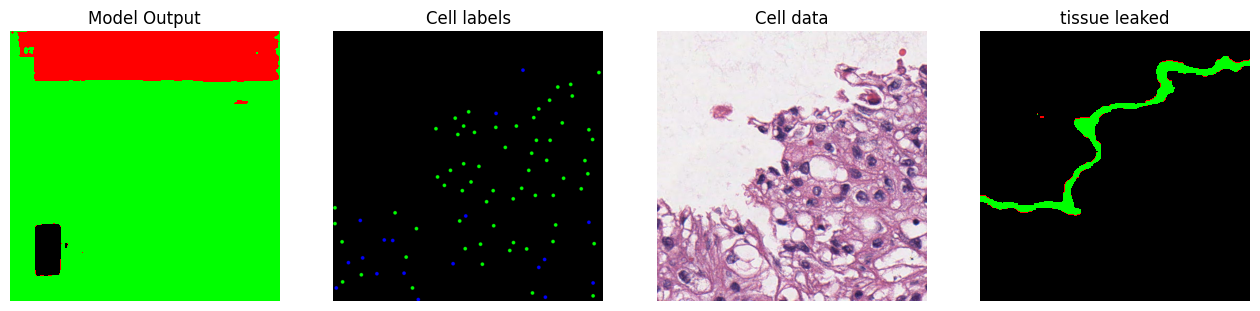

In [10]:
cell_image = inputs[0, :3]
tissue_labels = inputs[0, 3]
output_image = outputs.argmax(1)

# Setting the correct color for the labels
label_image = labels[0].permute((1, 2, 0)).numpy()
mask = np.all(label_image == [1, 0, 0], axis=-1)
label_image[mask] = [0, 0, 0]

plt.figure(figsize=(16, 8))  # Adjust the width and height as needed

plt.subplot(1, 4, 1)
plt.title("Model Output")
plt.axis("off")
plt.imshow(output_image[0], cmap=cmap)

plt.subplot(1, 4, 4)
plt.title("tissue leaked")
plt.imshow(tissue_labels, cmap=cmap)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Cell data")
plt.axis("off")
plt.imshow(cell_image.permute((1, 2, 0)))

plt.subplot(1, 4, 2)
plt.title("Cell labels")
plt.imshow(label_image*255)
plt.axis("off")


plt.show()